**This cell installs the ultralytics package, which is required to use YOLO (You Only Look Once) models for object detection.**

In [1]:
# Install requirements
!pip install ultralytics -q

**This cell imports the necessary libraries. ultralytics is used for the YOLO model, cv2 for computer vision tasks, matplotlib.pyplot for plotting, glob for file operations, PIL for image processing, pandas for data manipulation, os for operating system operations, random for generating random numbers, yaml for working with YAML files, numpy for numerical operations, matplotlib.patches for adding shapes to plots, and shutil for file operations.**

In [2]:
# Import libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import glob
from PIL import Image
import pandas as pd
import os
import random
import yaml
import numpy as np
import matplotlib.patches as patches
import shutil

This notebook will show how to train a YOLO8 model for object detection. We shall show how to:
1. Create YOLO format labels from the provided [CSV](https://github.com/AI-Lab-Makerere/CV4Agriculture_Hackathon24/blob/main/resources/cocoa_sample/label_map.csv)
2. Create train, validation and test datasets.
3. Train, Evaluate and Test a Baseline Model
4. Create  a submission file.
5. (Optional) - export a mobile optimized model

## Basic exploration

**This cell downloads the dataset from a specified URL and unzips the downloaded file.**

In [3]:
# Get the data
! wget https://storage.googleapis.com/air-lab-hackathon/Cocoa/cocoa_new.zip
! unzip cocoa_new.zip

--2024-05-25 10:03:47--  https://storage.googleapis.com/air-lab-hackathon/Cocoa/cocoa_new.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345573065 (330M) [application/zip]
Saving to: 'cocoa_new.zip'

cocoa_new.zip       100%[===================>] 329.56M   153MB/s    in 2.2s    

2024-05-25 10:03:50 (153 MB/s) - 'cocoa_new.zip' saved [345573065/345573065]

Archive:  cocoa_new.zip
   creating: cocoa_new/
   creating: cocoa_new/valid/
  inflating: cocoa_new/.DS_Store     
  inflating: __MACOSX/cocoa_new/._.DS_Store  
   creating: cocoa_new/test_new/
   creating: cocoa_new/train/
  inflating: cocoa_new/valid/img_2589_JPG_jpg.rf.2a1f2ea5bf804607a306cffc955f259e.jpg  
  inflating: cocoa_new/valid/img_3217_JPG_jpg.rf.194b60fb1f9d3d1778cd38e482311df8.jpg  
  inflating: coco

**This cell sets the path to the training data, counts the number of images in the directory, and prints the total number of images found.**

In [4]:
import pathlib
data_dir = 'cocoa_new/train/'
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*.jpg')))
print(f'Found {image_count} images')

Found 2274 images


Lets look at some of the images

**This cell creates a list of all image paths in the training directory and opens the first image in the list to display it.**

In [ ]:
image_list = list(data_dir.glob('*.jpg'))
Image.open(str(image_list[0]))

**This cell opens and displays the 13th image in the list of images.**

In [ ]:
Image.open(str(image_list[12]))

Lets visualize some of the data with the annotations. Ton do this, we shall load the bounding box coordinates from the label_map csv file and then draw them on the image.
lets define some helper functions.

**This cell loads the CSV file containing the labels for the training images and displays the first few rows of the dataframe.**

In [ ]:
# Load csv file
label_data = pd.read_csv('cocoa_new/train/label_map.csv')
label_data.head()

**This cell prints a concise summary of the dataframe, including the data types of each column and the number of non-null values.**

In [ ]:
# May need to check data types incase conversions need to be made
label_data.info()

**This cell outputs the column names of the dataframe.**

In [ ]:
label_data.columns

**This cell defines a function to extract the bounding box coordinates and the actual label for a given image ID from the dataframe.**

In [ ]:
def extract_bounding_boxes(df, img_id):
  return df[df['Image id']==img_id][['xmin', 'ymin', 'xmax', 'ymax', 'Actual Label']].values

**This cell defines a function to extract the normalized bounding box coordinates and the actual label for a given image ID from the dataframe.**

In [ ]:
def extract_bounding_boxes_norm(data_f, img_name):
  return data_f[data_f['Image id']==img_name][['xmin_norm', 'ymin_norm', 'xmax_norm', 'ymax_norm', 'Actual Label']].values

**This cell defines a function to plot an image with its bounding boxes. The bounding boxes and labels are drawn on the image.**

In [ ]:
def plot_image_with_bbox(img_path, bboxes):
    # Load image
    img_arr = Image.open(img_path)

    fig, ax = plt.subplots(1)

    ax.imshow(img_arr)

    for bbox in bboxes:
        x, y, x1, y1, img_lbl = bbox
        # print(img_lbl)
        w = x1-x
        h = y1-y
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.text(x, y,img_lbl, color='b')
        ax.add_patch(rect)

    plt.axis('off')  # Turn off axis
    plt.show()

**This cell selects a random image from the list, extracts its bounding boxes using the extract_bounding_boxes function, and plots the image with the bounding boxes drawn using the plot_image_with_bbox function.**

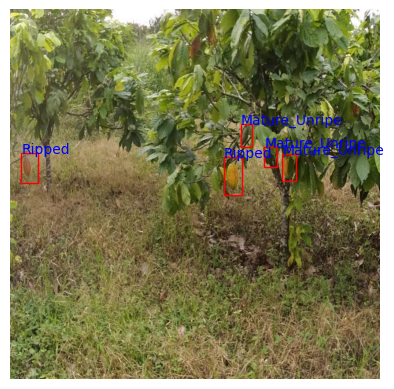

In [13]:
# Select a random sample
sample_image = random.choice(image_list)
sample_bboxes = extract_bounding_boxes(label_data, os.path.basename(sample_image))
plot_image_with_bbox(sample_image, sample_bboxes)

To train a YOLO8 model with ultralytics, we need to convert the dataset into the appropriate format. For this we shall:
1. Create YOLO format annotations from the labeled data. The yolo format is:   
 `class_id x_min y_min x_center ycenter`
2. Organize the directories for the dataset. We shall use:  
  - yolo-data  
    - train
      - images
      - labels
    - val
      - images
      - labels
    - test
      - images
      - labels


3. Create a YAML configuration file with the dataset directories documented.

**This cell creates the necessary directories for storing images and labels in the YOLO format. Separate directories are created for the base, training, validation, and test sets.**

In [14]:
# Create save directories
for d in ['base', 'train', 'val', 'test']:
  os.makedirs(f'yolo-data/{d}/images', exist_ok=True)
  os.makedirs(f'yolo-data/{d}/labels', exist_ok=True)

**This cell creates a mapping of the unique labels to numerical indices, which is required for YOLO training. It prints the unique labels and creates a dictionary to map each label to an index.**

In [15]:
# Create label mapping to class names
labels = label_data['Actual Label'].unique()
print(labels)


# Create a label map
cocoa_label_map = {val:idx[0] for  idx, val in np.ndenumerate(labels)}

cocoa_label_map

['Spoit' 'Immature' 'Mature_Unripe' 'Ripped']


{'Spoit': 0, 'Immature': 1, 'Mature_Unripe': 2, 'Ripped': 3}

**This cell defines a function to generate YOLO format labels for a given image. The labels are saved in a specified directory. The function extracts the bounding boxes, converts the coordinates, and writes them to a text file in the YOLO format.**

In [16]:
def generate_yolo_label(df, img_id, save_dir = 'yolo-data/base/labels/'):
  ext_boxes = extract_bounding_boxes_norm(df, img_id)
  img_width, img_height = (640,640)
  with open(save_dir+img_id[:-3]+'txt', 'w') as l_file:
    for b in ext_boxes:
      x1, y1, x2, y2, img_label =  b
      xc = x1+ (x2-x1)/2
      yc  = y1+ (y2-y1)/2
      l_file.write(f'{cocoa_label_map[img_label]} {x1:.6f} {y1:.6f} {xc:.6f} {yc:.6f}\n')


**This cell tests the generate_yolo_label function by generating a YOLO format label file for the sample image.**

In [17]:
# Test the function
generate_yolo_label(label_data, os.path.basename(sample_image))

# This should create a txt yolo format label file in yolo-data/base/labels

**This cell loops through all images in the list and generates YOLO format labels for each image.**

In [18]:
# Loop through label_data and genrate labels for all unique image ids
for i in image_list:
  generate_yolo_label(label_data, os.path.basename(i))

#### Create train test and validation datasets.

**This cell imports the train_test_split function from sklearn, which will be used to split the data into training, validation, and test sets.**

In [19]:
from sklearn.model_selection import train_test_split

**This cell retrieves all label files, splits them into training, validation, and test sets, and prints the number of samples in each set.**

In [20]:
# Get all labels
base_labels = glob.glob('yolo-data/base/labels/*.txt')
print(f'Found {len(base_labels)} files.')


train, temp = train_test_split(base_labels, test_size=0.3, random_state=3873)
val, test = train_test_split(temp, test_size=0.5, random_state=928)


print(f'Train has {len(train)} samples')
print(f'Val has {len(val)} samples')
print(f'Test has {len(test)} samples')

Found 2274 files.
Train has 1591 samples
Val has 341 samples
Test has 342 samples


**This cell copies the label and image files to their respective directories (train, validation, and test).**

In [21]:
# Copy files to respective folders
for f in train:
  i_name = os.path.basename(f)[:-3]+'jpg'
  shutil.copyfile(f, 'yolo-data/train/labels/'+os.path.basename(f))
  shutil.copyfile('cocoa_new/train/'+i_name, 'yolo-data/train/images/'+i_name)

for f in test:
  i_name = os.path.basename(f)[:-3]+'jpg'
  shutil.copyfile(f, 'yolo-data/test/labels/'+os.path.basename(f))
  shutil.copyfile('cocoa_new/train/'+i_name, 'yolo-data/test/images/'+i_name)

for f in val:
  i_name = os.path.basename(f)[:-3]+'jpg'
  shutil.copyfile(f, 'yolo-data/val/labels/'+os.path.basename(f))
  shutil.copyfile('cocoa_new/train/'+i_name, 'yolo-data/val/images/'+i_name)

### Create a YAML data configuration file for training

**This cell creates a YAML configuration file for the YOLO training process. The configuration includes paths to the data and a mapping of class indices to class names. The configuration is saved to data_config.yaml.**

In [22]:
yaml_dict = {
    'path': '/kaggle/working/yolo-data',
    'train': '/kaggle/working/yolo-data/train',
    'val': '/kaggle/working/yolo-data/val',
    'names': {idx[0]: val for  idx, val in np.ndenumerate(labels)}

}

with open('data_config.yaml', 'w+') as yml_file:
    yaml.dump(yaml_dict, yml_file)

## Model training


You can consider logging your runs to a service like [WandB](https://wandb.ai/site)

**This cell sets various training options, such as batch size, number of epochs, optimizer type, and paths to configuration files and project directories.**

In [41]:
# set some options
# Visit https://docs.ultralytics.com/modes/train/#train-settings to seee complete settings

batch = 16
patience = 20
epochs = 200
optimizer = 'AdamW'
data_config = '/kaggle/working/data_config.yaml'
project = 'cocoa-training' # folder where train runs will be stored
name = 'exp_v1.1'  # custom name for specific run folder, may need to make this dynamic

**This cell loads a pre-trained YOLO model. The specific version of the model to be used is specified (yolov8s.pt).**

In [42]:
# Load model
# Visit https://docs.ultralytics.com/ for more details about the YOLO model.
model_version = 'yolov8s.pt' # can pick from yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
model = YOLO(model_version)

**Check model benchmarks [here](https://docs.ultralytics.com/tasks/segment/#models)**

**This cell initializes Weights & Biases (wandB) for experiment tracking, which is optional but recommended for logging and monitoring training progress.**

In [25]:
# Initialize wandB (optional) but recommended
# !wandb init

**This cell trains the YOLO model using the specified configuration and parameters. The training results are stored in the results variable.**

In [43]:
# Train the model
results = model.train(data=data_config, epochs=epochs, imgsz=640, project=project, patience=patience, name=name,
                      batch=batch, optimizer=optimizer)

Ultralytics YOLOv8.2.21 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data_config.yaml, epochs=200, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=cocoa-training, name=exp_v1.17, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

wandb: Currently logged in as: juukojuniorfrancis (juuko-makerere). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/yolo-data/train/labels.cache... 1591 images, 10 backgrounds, 0 corrupt: 100%|██████████| 1591/1591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/yolo-data/val/labels.cache... 341 images, 1 backgrounds, 0 corrupt: 100%|██████████| 341/341 [00:00<?, ?it/s]


Plotting labels to cocoa-training/exp_v1.17/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to cocoa-training/exp_v1.17
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200        16G      2.142      3.116      2.541        117        640: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.99it/s]

                   all        341       1840   1.79e-05    0.00129   9.04e-06   1.81e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      4.61G      1.911      3.062        2.4         85        640: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]

                   all        341       1840    0.00534      0.284    0.00537    0.00136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      4.61G       1.87      3.006      2.354         64        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]

                   all        341       1840     0.0854      0.127     0.0419     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      4.62G      1.822      2.964      2.299         81        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.33it/s]

                   all        341       1840    0.00349        0.2    0.00434    0.00103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      4.62G      1.781      2.944      2.259         60        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.02it/s]

                   all        341       1840     0.0163     0.0281    0.00706    0.00228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      4.61G      1.764      2.908      2.252         54        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]

                   all        341       1840      0.141      0.127     0.0345     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      4.61G       1.72      2.851        2.2         86        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.70it/s]

                   all        341       1840     0.0262      0.115      0.013    0.00392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      4.61G       1.69      2.827      2.182         46        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.49it/s]

                   all        341       1840      0.133      0.154     0.0763     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      4.62G      1.677      2.784      2.169         64        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]

                   all        341       1840      0.411      0.149      0.094     0.0373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      4.62G      1.658      2.757      2.144         69        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        341       1840      0.127      0.248      0.115      0.052



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      4.61G      1.632      2.741      2.116         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

                   all        341       1840     0.0978      0.163      0.076     0.0266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      4.62G      1.597      2.708      2.109         75        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

                   all        341       1840      0.431      0.126     0.0994     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      4.61G       1.58       2.69      2.097         78        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.47it/s]

                   all        341       1840      0.355      0.139     0.0737     0.0258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      4.61G      1.582      2.651      2.104         89        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]

                   all        341       1840      0.134       0.23       0.11      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      4.61G      1.576      2.623      2.095        103        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        341       1840      0.216      0.219      0.166     0.0823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      4.62G      1.536      2.606      2.065         83        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.42it/s]

                   all        341       1840      0.181      0.293      0.152      0.063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.63G      1.537      2.584      2.068         60        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

                   all        341       1840      0.177      0.179     0.0932      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.62G      1.532      2.567      2.035         88        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]

                   all        341       1840      0.455      0.254      0.194     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.61G      1.495       2.53      2.022         62        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.29it/s]

                   all        341       1840      0.186      0.281      0.193     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      4.61G      1.492      2.492      2.022         72        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.21it/s]

                   all        341       1840      0.241      0.312      0.188      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.61G      1.479      2.481      2.023         58        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]

                   all        341       1840      0.273      0.304      0.215     0.0937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      4.61G      1.456      2.445      1.996        106        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.26it/s]

                   all        341       1840      0.455      0.345       0.25      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.61G       1.47      2.467      2.012         76        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]

                   all        341       1840      0.207      0.324      0.206      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.61G      1.443       2.41      1.986         75        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]

                   all        341       1840      0.244       0.33      0.222      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.62G      1.448      2.411      1.992         98        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

                   all        341       1840      0.301      0.379      0.254       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      4.62G      1.441      2.423      1.979         56        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]

                   all        341       1840      0.282      0.356      0.252      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.61G      1.451      2.392      1.987        102        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


                   all        341       1840      0.281       0.33      0.231      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.61G      1.433      2.386      1.981         60        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

                   all        341       1840      0.436      0.331      0.202      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.61G      1.413      2.336      1.968         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]

                   all        341       1840      0.253       0.39      0.266      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.61G      1.416       2.34      1.962        119        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

                   all        341       1840       0.24       0.36      0.248      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.62G      1.393      2.317      1.943         78        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]

                   all        341       1840      0.274      0.385      0.265      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.62G      1.399      2.332      1.952         70        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]

                   all        341       1840      0.319      0.331      0.251      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.61G      1.387      2.332      1.935         66        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]

                   all        341       1840      0.247      0.311      0.238      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.61G      1.396      2.302      1.952         55        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

                   all        341       1840       0.28      0.442      0.251      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.61G      1.371      2.285      1.921         61        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

                   all        341       1840      0.231      0.324      0.209     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.61G      1.367      2.295       1.93         60        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]

                   all        341       1840       0.27      0.456      0.266      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.61G      1.359      2.268      1.928         77        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.54it/s]

                   all        341       1840      0.224      0.426      0.237      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      4.61G      1.358      2.263      1.922         85        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]

                   all        341       1840      0.273      0.414      0.265      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200       4.6G      1.341       2.23      1.913         71        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]


                   all        341       1840      0.271      0.401      0.272      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.61G      1.339      2.245      1.914         39        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]

                   all        341       1840      0.256      0.451      0.274      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.61G      1.333      2.239      1.915         57        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]

                   all        341       1840      0.382      0.383       0.27      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      4.61G      1.339      2.235      1.913         71        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

                   all        341       1840       0.26      0.448       0.27      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200       4.6G      1.324      2.222      1.902         72        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


                   all        341       1840      0.294      0.442      0.295      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.61G       1.33      2.201      1.908         97        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

                   all        341       1840      0.264      0.455       0.28      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.61G      1.311      2.213      1.897        122        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        341       1840      0.289      0.445      0.297      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.61G       1.33      2.232      1.899         49        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.28it/s]

                   all        341       1840      0.296      0.387      0.266       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      4.61G      1.312      2.219      1.897         65        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

                   all        341       1840      0.296      0.459      0.308      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200       4.6G      1.314        2.2      1.905         41        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.49it/s]

                   all        341       1840      0.297      0.398      0.265      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.61G      1.298      2.194      1.892         82        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]


                   all        341       1840      0.249       0.42      0.289      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200       4.6G      1.278      2.158      1.866         77        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.62it/s]

                   all        341       1840      0.228       0.43       0.25      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      4.62G      1.279      2.175       1.87         64        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.56it/s]

                   all        341       1840      0.249      0.432      0.282      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      4.62G      1.272      2.154      1.859         90        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        341       1840      0.329      0.365      0.294      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      4.61G      1.277       2.16      1.859         58        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]

                   all        341       1840      0.252      0.448      0.283      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      4.61G      1.266      2.146      1.854         44        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

                   all        341       1840      0.254      0.469       0.29      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200       4.6G      1.254      2.136       1.85        117        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


                   all        341       1840      0.276      0.421      0.285      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200       4.6G      1.253      2.152      1.848         69        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        341       1840      0.299      0.433      0.311      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      4.61G      1.268      2.139      1.867         96        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.50it/s]

                   all        341       1840      0.284      0.449      0.308      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      4.61G      1.242       2.13      1.849         70        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.57it/s]

                   all        341       1840       0.28      0.439      0.298      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      4.61G      1.252      2.142      1.852         86        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]

                   all        341       1840      0.299      0.463      0.319      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      4.61G      1.247      2.142      1.865         54        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]


                   all        341       1840      0.281       0.47      0.306      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200       4.6G      1.246      2.149      1.855         70        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

                   all        341       1840      0.271      0.461      0.294      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200       4.6G      1.231      2.104      1.842         66        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]


                   all        341       1840      0.297      0.462      0.297       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      4.61G       1.23      2.108      1.835         74        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]


                   all        341       1840      0.305      0.425      0.307      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      4.61G      1.235      2.125      1.832         70        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.60it/s]


                   all        341       1840      0.329      0.402      0.303      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      4.61G      1.211       2.11      1.821         60        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]


                   all        341       1840      0.289      0.457      0.321      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200       4.6G      1.222      2.113      1.831         80        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

                   all        341       1840      0.374      0.408      0.319      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200       4.6G      1.218      2.101      1.817         84        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]

                   all        341       1840      0.312      0.495      0.329      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200       4.6G      1.206      2.092       1.82         86        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]


                   all        341       1840      0.295      0.472      0.324      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.61G        1.2      2.075      1.812         70        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.51it/s]

                   all        341       1840      0.314      0.477       0.35      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      4.61G       1.22      2.088      1.835         24        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]

                   all        341       1840      0.289      0.444      0.323      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.61G      1.223      2.078      1.829         68        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


                   all        341       1840      0.312      0.469      0.341      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200       4.6G      1.207      2.076      1.809         82        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


                   all        341       1840      0.269      0.474      0.309      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.61G      1.199      2.061      1.814        105        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]


                   all        341       1840      0.308      0.432      0.325       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200       4.6G       1.19      2.071      1.806         79        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]


                   all        341       1840      0.323      0.489      0.356      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.61G      1.187      2.063      1.795         72        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]

                   all        341       1840      0.317      0.467      0.335      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.61G      1.172      2.034      1.782        111        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]


                   all        341       1840       0.31      0.496      0.337      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.61G       1.18      2.053      1.794         67        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]

                   all        341       1840      0.322      0.462      0.333      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200       4.6G      1.172      2.023      1.783        100        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]

                   all        341       1840      0.321      0.467      0.342      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200       4.6G       1.17      2.026       1.78         84        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]

                   all        341       1840       0.35      0.497      0.355       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200       4.6G       1.18      2.028      1.789         78        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

                   all        341       1840      0.315      0.476      0.339      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200       4.6G      1.168      2.009      1.791         97        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]

                   all        341       1840      0.291      0.496      0.322       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200       4.6G      1.184      2.039      1.806         83        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.64it/s]


                   all        341       1840      0.351      0.466      0.375      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.61G      1.145      1.997      1.763         62        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        341       1840      0.323      0.492      0.347      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.61G       1.15      2.004      1.769         42        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        341       1840      0.344      0.471      0.355      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.61G      1.155          2      1.771         61        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]

                   all        341       1840      0.338      0.515      0.373      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200       4.6G      1.166      1.983      1.776         33        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


                   all        341       1840      0.344      0.517      0.388      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200       4.6G       1.17      2.016      1.779         72        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        341       1840      0.348      0.479      0.364      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200       4.6G      1.139       1.99      1.766         50        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]


                   all        341       1840      0.303      0.486      0.331      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200       4.6G      1.158      2.002      1.781         84        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]

                   all        341       1840      0.342      0.513      0.388      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200       4.6G      1.151      1.982      1.774         97        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]


                   all        341       1840      0.341      0.472      0.345      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200       4.6G      1.151      1.983      1.768         61        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]

                   all        341       1840      0.321      0.503      0.359      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200       4.6G      1.145      1.984       1.77         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]

                   all        341       1840      0.318      0.552      0.363       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.61G      1.145      1.962      1.769         88        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

                   all        341       1840      0.358      0.492      0.383      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.61G      1.136      1.971      1.763         64        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]

                   all        341       1840      0.342        0.5      0.381      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      4.61G      1.122      1.966      1.756         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]

                   all        341       1840      0.364      0.494      0.383      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.61G      1.126       1.97      1.743         76        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]


                   all        341       1840      0.358      0.506      0.378      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200       4.6G      1.128      1.932      1.747         65        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]


                   all        341       1840      0.373      0.513      0.391      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.61G      1.112      1.938      1.743         57        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


                   all        341       1840      0.353      0.525      0.392      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200       4.6G      1.121      1.941      1.755        114        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

                   all        341       1840      0.396      0.464      0.398      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       4.6G      1.139      1.955      1.759        135        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        341       1840      0.359      0.477      0.382      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.61G      1.115      1.931      1.743         49        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]

                   all        341       1840       0.38      0.512      0.414      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.61G      1.103      1.912      1.733        105        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.28it/s]

                   all        341       1840      0.379      0.477       0.39      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.61G      1.108      1.929      1.728         92        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        341       1840      0.384      0.487      0.388      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200       4.6G       1.11       1.92      1.731         67        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]


                   all        341       1840        0.4      0.509      0.419      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200       4.6G      1.104      1.913       1.72         70        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.68it/s]

                   all        341       1840      0.358      0.496      0.398      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200       4.6G       1.11      1.919      1.736        103        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]

                   all        341       1840      0.381      0.483      0.401      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.61G      1.098      1.899      1.733         93        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]


                   all        341       1840       0.37      0.489       0.39      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.62G      1.108      1.899      1.747         93        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]

                   all        341       1840      0.368      0.498      0.392      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.61G      1.093      1.898      1.721         95        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]

                   all        341       1840      0.393      0.518      0.421      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200       4.6G      1.103      1.888      1.731         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]


                   all        341       1840      0.377      0.464      0.394       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200       4.6G      1.092      1.897      1.717         77        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]


                   all        341       1840      0.392      0.526      0.423      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.61G        1.1       1.88      1.714         69        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]

                   all        341       1840      0.447      0.482      0.445      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.61G      1.104      1.878      1.721         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]

                   all        341       1840      0.396      0.475      0.397      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200       4.6G      1.084       1.87      1.709         97        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]

                   all        341       1840       0.43      0.479      0.431      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.61G      1.085      1.832      1.706         72        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.74it/s]

                   all        341       1840      0.386      0.508       0.41      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200       4.6G      1.096      1.849      1.714         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]


                   all        341       1840       0.41      0.496      0.424      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.61G      1.068      1.834        1.7         77        640: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]

                   all        341       1840      0.412      0.515      0.443      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.61G      1.072      1.838      1.698         67        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.63it/s]

                   all        341       1840      0.439      0.513      0.453      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.61G      1.085      1.839      1.708         79        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]

                   all        341       1840      0.441      0.529      0.472      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200       4.6G      1.072      1.835      1.702         57        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]


                   all        341       1840      0.432      0.491      0.439      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200       4.6G      1.071      1.817      1.695         68        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

                   all        341       1840      0.423      0.498      0.427      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.61G      1.055      1.828      1.683         55        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.71it/s]

                   all        341       1840      0.435      0.508      0.458      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200       4.6G      1.062      1.799      1.685         81        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

                   all        341       1840      0.424      0.535      0.463      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200       4.6G      1.066       1.82      1.693         64        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

                   all        341       1840       0.43      0.507      0.444      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      4.61G      1.066      1.793      1.698        121        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]

                   all        341       1840      0.448      0.523      0.476      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200       4.6G      1.059      1.767      1.695         74        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]


                   all        341       1840      0.452      0.524      0.466      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      4.61G      1.062      1.777      1.693         72        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


                   all        341       1840      0.492      0.489      0.496       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      4.61G      1.029      1.766      1.662         57        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

                   all        341       1840      0.432      0.514      0.463      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      4.61G       1.05      1.763      1.685         78        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]

                   all        341       1840      0.447      0.538      0.491      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200       4.6G      1.033      1.753      1.667         65        640: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

                   all        341       1840      0.478      0.524      0.474      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      4.61G      1.052       1.76      1.686        100        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]

                   all        341       1840      0.484      0.493      0.491       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200       4.6G      1.028      1.723       1.66         79        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

                   all        341       1840      0.458       0.53      0.483      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200       4.6G      1.045       1.76      1.664         88        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]


                   all        341       1840      0.463      0.489      0.473      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200       4.6G      1.042      1.748      1.676         85        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


                   all        341       1840      0.507      0.499        0.5      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      4.61G      1.022      1.723       1.65         68        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]

                   all        341       1840      0.489      0.534      0.523       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      4.61G      1.016      1.695      1.644         82        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.78it/s]


                   all        341       1840      0.456      0.554      0.508      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      4.61G      1.027      1.707      1.651         51        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]


                   all        341       1840      0.521       0.51      0.521      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.62G      1.025      1.694      1.646         62        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]

                   all        341       1840      0.548      0.491      0.531      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      4.61G      1.028      1.709      1.664        127        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

                   all        341       1840      0.539      0.495      0.544      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200       4.6G      1.029      1.726      1.661         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]

                   all        341       1840      0.567      0.499      0.522       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200       4.6G      1.012      1.681      1.638         94        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]

                   all        341       1840      0.556      0.526       0.55        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200       4.6G      1.009      1.708      1.633         92        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

                   all        341       1840      0.584       0.48      0.554      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      4.61G      1.018      1.678      1.649         46        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]

                   all        341       1840      0.527      0.557      0.561      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      4.61G     0.9949      1.664      1.628         88        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]

                   all        341       1840      0.483      0.566      0.534      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      4.61G      1.006      1.652      1.635         83        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


                   all        341       1840      0.554      0.532      0.563      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200       4.6G      1.002      1.684       1.63         85        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

                   all        341       1840      0.541      0.506      0.542       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200       4.6G      1.005      1.675      1.626         88        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]

                   all        341       1840      0.518      0.578       0.57      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200       4.6G     0.9951       1.65      1.626        107        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]


                   all        341       1840      0.539      0.514      0.545      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      4.62G      1.003      1.659      1.639         58        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]

                   all        341       1840      0.511      0.532       0.55      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      4.61G      0.977      1.622      1.606        108        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]

                   all        341       1840      0.614      0.509      0.584      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      4.61G     0.9938      1.626      1.619         89        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


                   all        341       1840      0.601      0.529      0.591      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200       4.6G     0.9879      1.624      1.617         92        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


                   all        341       1840      0.579      0.548      0.577      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200       4.6G     0.9795      1.609      1.605         78        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.75it/s]

                   all        341       1840      0.661      0.464       0.58      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200       4.6G     0.9714      1.602      1.603         88        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]

                   all        341       1840       0.59      0.554      0.594      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200       4.6G     0.9747      1.614        1.6         57        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


                   all        341       1840      0.576      0.547      0.576      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200       4.6G      0.985      1.607      1.608        120        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]

                   all        341       1840      0.624      0.509      0.574      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200       4.6G     0.9707        1.6      1.601        103        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

                   all        341       1840      0.635      0.552        0.6      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200       4.6G     0.9714       1.59      1.602         53        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

                   all        341       1840      0.605      0.557       0.59      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      4.73G     0.9733      1.591      1.597         66        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]


                   all        341       1840      0.586      0.575      0.591      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200       4.6G     0.9642       1.58      1.596         81        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]


                   all        341       1840      0.633      0.525        0.6       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200       4.6G     0.9519      1.569      1.587         60        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]


                   all        341       1840      0.629       0.53      0.611      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200       4.6G     0.9579       1.58      1.585         75        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]

                   all        341       1840      0.583      0.574      0.603      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200       4.6G     0.9567       1.56      1.587        108        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

                   all        341       1840      0.647      0.547      0.623      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200       4.6G     0.9582      1.561      1.579         66        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.77it/s]


                   all        341       1840      0.613      0.588       0.62      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200       4.6G      0.953      1.568       1.58         70        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


                   all        341       1840      0.646      0.531      0.609      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      4.61G     0.9481      1.562      1.575         94        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


                   all        341       1840      0.644      0.558      0.615      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200       4.6G     0.9606      1.555      1.584         64        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

                   all        341       1840      0.652      0.561      0.614      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200       4.6G     0.9541      1.557      1.586         64        640: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.65it/s]

                   all        341       1840      0.641      0.553       0.62      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      4.61G     0.9637      1.569      1.588         99        640: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.87it/s]


                   all        341       1840       0.63      0.575      0.622      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      4.61G     0.9428      1.549      1.577         75        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.85it/s]


                   all        341       1840      0.625      0.567      0.639      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      4.61G     0.9413      1.531      1.563         66        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


                   all        341       1840      0.628      0.587      0.634      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      4.61G     0.9423      1.533      1.575         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]


                   all        341       1840      0.591       0.59      0.623      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      4.61G     0.9362       1.52      1.567         75        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


                   all        341       1840        0.6      0.609      0.636      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200       4.6G     0.9349      1.519       1.56         78        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.73it/s]


                   all        341       1840      0.639       0.58       0.64      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200       4.6G     0.9333      1.518      1.562         65        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]

                   all        341       1840      0.616      0.614      0.645      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      4.61G     0.9233       1.51      1.556         51        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]


                   all        341       1840      0.692      0.539      0.625      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      4.61G     0.9416      1.528      1.565         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


                   all        341       1840      0.681      0.541      0.633      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      4.62G     0.9265      1.514      1.557         88        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


                   all        341       1840      0.688      0.555      0.628      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      4.61G     0.9319      1.504      1.558        119        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]


                   all        341       1840       0.64      0.592      0.642      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200       4.6G      0.925      1.509      1.551         77        640: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]


                   all        341       1840      0.659       0.57      0.643      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200       4.6G     0.9241        1.5      1.551         73        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

                   all        341       1840      0.649       0.58      0.642      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200       4.6G     0.9426      1.505       1.57        100        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]


                   all        341       1840       0.65      0.582      0.655      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      4.61G     0.9315      1.492      1.561        100        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]

                   all        341       1840      0.641      0.589      0.651      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      4.61G      0.927      1.521      1.555         80        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]

                   all        341       1840      0.635      0.609      0.646      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      4.61G     0.9168      1.473       1.55         91        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]

                   all        341       1840      0.622      0.616      0.649      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200       4.6G     0.9097      1.462      1.542         53        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.83it/s]

                   all        341       1840      0.695       0.55      0.652       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200       4.6G     0.9154      1.469      1.541         57        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]

                   all        341       1840      0.635      0.614      0.665       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200       4.6G     0.9063      1.472      1.539         53        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.85it/s]


                   all        341       1840      0.669      0.601      0.662      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200       4.6G      0.913      1.481      1.541         72        640: 100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

                   all        341       1840      0.671      0.607      0.665      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      4.61G     0.9181      1.474      1.542         60        640: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.88it/s]


                   all        341       1840      0.643      0.617      0.659      0.482
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      4.61G     0.8268      1.229      1.575         43        640: 100%|██████████| 100/100 [00:31<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.70it/s]


                   all        341       1840      0.621      0.568      0.627      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      4.61G     0.7416      1.108      1.461         38        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]

                   all        341       1840      0.623      0.575      0.628      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      4.61G     0.7397      1.063      1.461         45        640: 100%|██████████| 100/100 [00:29<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.61it/s]

                   all        341       1840      0.618        0.6      0.642      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200       4.6G     0.7253      1.051      1.449         36        640: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.79it/s]

                   all        341       1840      0.635      0.599      0.648      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200       4.6G     0.7237      1.043      1.445         47        640: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.85it/s]


                   all        341       1840      0.635       0.59      0.642      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200       4.6G     0.7158      1.035      1.432         32        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

                   all        341       1840      0.633      0.603      0.646      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      4.61G     0.7161      1.031      1.437         39        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]


                   all        341       1840      0.614      0.618      0.655       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      4.61G     0.7034      1.027      1.419         45        640: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

                   all        341       1840       0.64      0.602      0.659      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200       4.6G     0.7189      1.038      1.444         54        640: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.86it/s]


                   all        341       1840       0.67      0.591       0.66      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200       4.6G     0.6992      1.015      1.422         21        640: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  3.81it/s]

                   all        341       1840      0.665      0.585      0.656      0.488



200 epochs completed in 1.918 hours.
Optimizer stripped from cocoa-training/exp_v1.17/weights/last.pt, 22.5MB
Optimizer stripped from cocoa-training/exp_v1.17/weights/best.pt, 22.5MB

Validating cocoa-training/exp_v1.17/weights/best.pt...
Ultralytics YOLOv8.2.21 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


                   all        341       1840       0.67      0.592       0.66      0.495
                 Spoit        341        387      0.708      0.618      0.702      0.525
              Immature        341        555      0.602      0.521       0.59      0.439
         Mature_Unripe        341        845      0.649      0.588      0.642      0.488
                Ripped        341         53       0.72      0.642      0.708      0.527
Speed: 0.2ms preprocess, 4.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to cocoa-training/exp_v1.17


lr/pg0,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▂▃▄▄▄▄▄▄▄▄▄▄▄▅▅▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████████
metrics/mAP50-95(B),▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
metrics/precision(B),▁▂▅▃▆▄▄▄▄▄▄▄▄▄▄▄▅▄▄▅▅▅▆▅▅▅▆▇▆▆▇▇▇█▇█▇█▇█
metrics/recall(B),▃▁▁▃▄▄▄▆▆▅▄▅▆▆▆▆▆▆▇▇▆▆▆▇▇▇▆▆▇▇▇▇█▇█▇████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁


**This cell evaluates the trained model on the validation set and stores the evaluation metrics in the metrics variable.**

In [46]:
# Evaluate the model
metrics = model.val()

Ultralytics YOLOv8.2.21 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/working/yolo-data/val/labels.cache... 341 images, 1 backgrounds, 0 corrupt: 100%|██████████| 341/341 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.61it/s]


                   all        341       1840      0.671      0.591       0.66      0.495
                 Spoit        341        387       0.71      0.618      0.701      0.526
              Immature        341        555      0.601      0.518      0.589       0.44
         Mature_Unripe        341        845       0.65      0.588      0.642      0.488
                Ripped        341         53      0.721      0.642      0.708      0.527
Speed: 0.2ms preprocess, 5.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to cocoa-training/exp_v1.172


You can view the results in the saved directory as shown above.  
In this case, results have been stored to the directory `cocoa-training/exp_v1.1/`

# Make Predictions

**This cell evaluates the model again (optional redundancy) and then loads the test data. The model makes predictions on the test data, saving the results and configuring the display settings for the predictions.**

In [47]:
metrics = model.val()

# Load test data
test_data = glob.glob('/kaggle/working/cocoa_new/test_new/*.jpg')

# Predict on test data
results = model.predict(test_data, save=True, show_labels=False, show_conf=False, conf=0.01)



Ultralytics YOLOv8.2.21 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)


val: Scanning /kaggle/working/yolo-data/val/labels.cache... 341 images, 1 backgrounds, 0 corrupt: 100%|██████████| 341/341 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:08<00:00,  2.66it/s]


                   all        341       1840      0.671      0.591       0.66      0.495
                 Spoit        341        387       0.71      0.618      0.701      0.526
              Immature        341        555      0.601      0.518      0.589       0.44
         Mature_Unripe        341        845       0.65      0.588      0.642      0.488
                Ripped        341         53      0.721      0.642      0.708      0.527
Speed: 0.2ms preprocess, 5.2ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to cocoa-training/exp_v1.173

0: 640x640 1 Spoit, 7 Immatures, 15 Mature_Unripes, 4.1ms
1: 640x640 3 Spoits, 4 Immatures, 9 Mature_Unripes, 4.1ms
2: 640x640 20 Spoits, 11 Immatures, 7 Mature_Unripes, 4.1ms
3: 640x640 2 Spoits, 2 Rippeds, 4.1ms
4: 640x640 2 Spoits, 4 Immatures, 11 Mature_Unripes, 4.1ms
5: 640x640 6 Spoits, 5 Mature_Unripes, 3 Rippeds, 4.1ms
6: 640x640 2 Mature_Unripes, 1 Ripped, 4.1ms
7: 640x640 2 Spoits, 18 Immatures, 7 Mature_Unripes, 4.

You can find results in the specified folder under the save dir.  
Let's explore what is in our predictions.

**This cell prints the number of prediction results obtained from the model.**

In [49]:
print(len(results))

317


The results contain predictions for each input image.  
Lets look at one.

**This cell displays the prediction results for the 8th image in the test set (index 7).**

In [51]:
results[7]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Spoit', 1: 'Immature', 2: 'Mature_Unripe', 3: 'Ripped'}
obb: None
orig_img: array([[[ 87, 114, 104],
        [ 97, 124, 114],
        [ 71, 101,  90],
        ...,
        [  6,  72,  61],
        [  8,  77,  66],
        [  8,  82,  70]],

       [[ 62,  89,  79],
        [ 73, 100,  90],
        [ 56,  86,  75],
        ...,
        [  8,  71,  61],
        [  8,  77,  66],
        [  8,  82,  70]],

       [[ 37,  64,  54],
        [ 47,  74,  64],
        [ 38,  68,  57],
        ...,
        [  9,  72,  62],
        [  8,  77,  66],
        [ 10,  82,  70]],

       ...,

       [[ 92, 128, 122],
        [103, 139, 133],
        [ 65, 102,  94],
        ...,
        [118, 118, 148],
        [117, 117, 147],
        [108, 108, 138]],

       [[ 65, 101,  95],
        [ 81, 117, 111],
        [ 70, 104,  98],
        ...,
        [117, 11

This returns a dictionary of many values.   
We are mainly interested in the boxes data.

**This cell retrieves the bounding boxes from the predictions of the 8th image in the test set.**

In [52]:
# Get boxes from predictions
results[7].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 0., 2., 1., 0., 1.], device='cuda:0')
conf: tensor([0.8860, 0.8574, 0.7479, 0.7410, 0.7242, 0.5651, 0.5366, 0.5051, 0.3887, 0.3391, 0.3049, 0.2627, 0.2218, 0.1997, 0.1204, 0.1169, 0.0452, 0.0403, 0.0392, 0.0371, 0.0315, 0.0188, 0.0183, 0.0149, 0.0126, 0.0101, 0.0101], device='cuda:0')
data: tensor([[1.8292e+02, 6.3175e+01, 5.5305e+02, 3.8232e+02, 8.8600e-01, 1.0000e+00],
        [2.2166e+02, 1.4560e+02, 6.3900e+02, 5.5188e+02, 8.5735e-01, 1.0000e+00],
        [2.0476e+02, 8.9235e+01, 6.1441e+02, 4.4882e+02, 7.4792e-01, 1.0000e+00],
        [2.5605e+02, 4.8472e+00, 6.4000e+02, 3.4246e+02, 7.4101e-01, 2.0000e+00],
        [2.1067e+02, 2.9524e+02, 6.3193e+02, 6.4000e+02, 7.2422e-01, 1.0000e+00],
        [1.5666e+02, 1.5467e+02, 4.8414e+02, 4.8582e+02, 5.6512e-01, 1.0000e+00],
        [2.1970e+02, 4.5971e+01, 6.4000e+02, 3.9596e+02, 

This also returns a dictionary of many values. The values of interest are:  
1. **xywh** - This returns the bounding box coordinates in an array representing `[x_min, y_min, bounding_box_width , bounding_box_height]`
2. **xyxy** - This returns the bounding box coordinates in an array representing `[x_min, y_min, x_max , y_max]`
3. The values **xywhn** and **xyxyn** are the same as above only that they are normalized. In this case, the bounding box coordinates in `xyxyn` are what we need to prepare our submission file.
4. The **conf** returns the confidences of the bounding boxes.
5. The **cls** value returns the classes predicted for each bounding box


**This cell extracts normalized coordinates, predicted classes, and confidence values from the prediction results. It also gets the filenames associated with each prediction and prints the shapes of the extracted arrays along with the length of the filenames list.**

In [53]:
# We shall extract the normalized coordinates as that is what we are interested in
# We shall also get the predicted classes. For this we shall use the label map to get the actual class later
# Finally we shall get the confidence values of the predictions.

filenames = [os.path.basename(r.path) for idx, r in enumerate(results) for b in r.boxes.xyxyn.cpu().numpy()]
pred_boxes = np.concatenate([r.boxes.xyxyn.cpu().numpy() for r in results])
pred_classes = np.concatenate([r.boxes.cls.cpu().numpy() for r in results])
pred_confidence = np.concatenate([r.boxes.conf.cpu().numpy() for r in results])
# for r in results:
#   pred_boxes = np.append(r.boxes.xyxyn.cpu().numpy())
# results[7].boxes.xyxyn.cpu().numpy()

### Creating a Submission file
The CSv must have 7 columns:  
`filename, Class, Confidence, ymin, xmin, ymax, xmax`.   

Each row represents a detected bounding box in an image.  
 - Class: The cocoa class (e.g. cocoa mature unripe, cocoa immature, cocoa ripped or cocoa spoilt.)
 - Confidence: Confidence score of the detection (between 0 and 1)
 - ymin, xmin, ymax, xmax: Normalized bounding box coordinates (between 0 and 1).

  - ymin: Top-left y-coordinate (0 at the top of the image)
  - xmin: Top-left x-coordinate (0 at the left of the image)
  - ymax: Bottom-right y-coordinate (1 at the bottom of the image)
  - xmax: Bottom-right x-coordinate (1 at the right of the image)


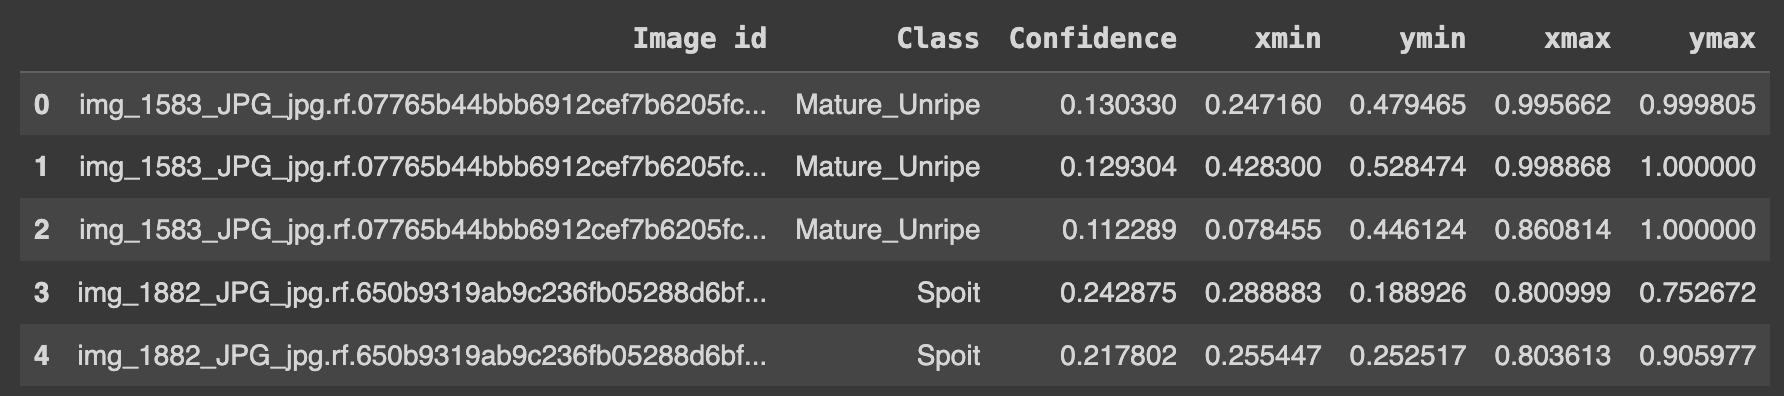

In [54]:
# Lets reverse the labelmap
cocoa_label_map_rev = {cocoa_label_map[key]:key for key in cocoa_label_map}
cocoa_label_map_rev

{0: 'Spoit', 1: 'Immature', 2: 'Mature_Unripe', 3: 'Ripped'}

In [55]:
# Get Actual Labels by from predicted classes
pred_labels = list(map(lambda x : cocoa_label_map_rev[x], list(pred_classes.astype(int))))

In [56]:
submission_df = pd.DataFrame(
    {
        'Image id': filenames,
        'Class': pred_labels,
        'Confidence': pred_confidence,
        'xmin': pred_boxes[:, 0],
        'ymin': pred_boxes[:, 1],
        'xmax': pred_boxes[:, 2],
        'ymax': pred_boxes[:, 3],

    }
)

submission_df.head()

,Image id,Class,Confidence,xmin,ymin,xmax,ymax
0,img_4029_JPG_jpg.rf.614a4d256edb4bb4b036632dee...,Mature_Unripe,0.840594,0.352127,0.144871,1.000000,0.744344
1,img_4029_JPG_jpg.rf.614a4d256edb4bb4b036632dee...,Mature_Unripe,0.749130,0.369551,0.055101,1.000000,0.640659
2,img_4029_JPG_jpg.rf.614a4d256edb4bb4b036632dee...,Mature_Unripe,0.632832,0.179969,0.000406,0.670660,0.289028
3,img_4029_JPG_jpg.rf.614a4d256edb4bb4b036632dee...,Mature_Unripe,0.441344,0.272559,0.287912,0.908905,0.933954
4,img_4029_JPG_jpg.rf.614a4d256edb4bb4b036632dee...,Immature,0.325939,0.278525,0.270015,0.924653,0.895671


In [ ]:
submission_df

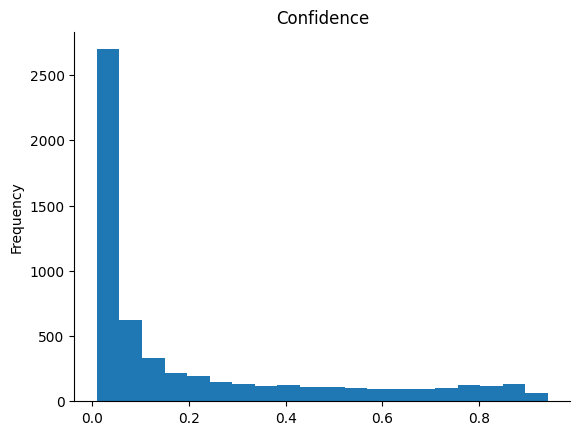

In [57]:
# @title Confidence

from matplotlib import pyplot as plt
submission_df['Confidence'].plot(kind='hist', bins=20, title='Confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [58]:
# Save to a CSV
submission_df.to_csv('ENIAC.csv', index=False)

Ensure that your CSV is named with your team name. For example if the team name is Expendables, the CSV must be saves as `Expendables.csv`

## Optional- Export to tflite model for mobile inference

In [ ]:
# Export model
# form = "tflite"
# model.export(format=form)

In [45]:
!pip freeze > requirements.txt

vbn